# Exoplanet hunting 
### Rowan Lavelle B455 Final Project
Problem space: Attempting to classify exoplanets based on light fluctuation data. This is a tricky problem to solve due to the fact that the data set surroudning this problem space is highly unbalanced. For this reason its difficult to make classfiers that predict the data well, we care more about the resulting confusion matrix than the actual testing and training accuracies. This is because if we just classify the who data set as non-exoplanets we will get "good" testing and training accuracies, but the accuracies are not real. For this reason the confusion matrix from sklearn metrics is a very usefull tool. It tell us all false positives, true positives, false negative and true negatives.

In [6]:
import warnings
warnings.simplefilter('ignore')

In [7]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import imblearn
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from scipy import fft
from scipy.ndimage.filters import gaussian_filter
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

#### Pull in the light fluctuation training and testing data

In [8]:
train = pd.read_csv('../data/exoTrain.csv')
test = pd.read_csv('../data/exoTest.csv')

the data is columns of light intesnsities as time goes on, with a prediction label. label==2 corrisponds to a exoplanet, and label==1 corresponds to a non exo planet. This is a highly unblanaced data set with only 37 exoplanets in the training set, out of 5087. And the testing set has 5 exoplanets out of 570 total points.

#### Split into labels and predictors 

In [9]:
x_train = pd.DataFrame(train[train.columns[1:]])
y_train = pd.DataFrame(train[train.columns[0]]).values

x_test = pd.DataFrame(test[test.columns[1:]])
y_test = pd.DataFrame(test[test.columns[0]]).values

# to set the label from 2,1 -> 1,0
y_test = y_test-1.0
y_train = y_train-1.0

#### Taking a look at the data

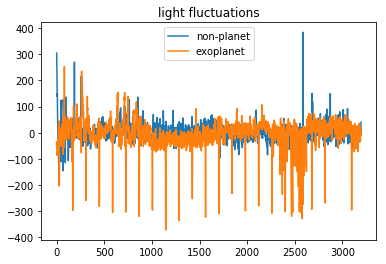

In [10]:
planet = x_train.iloc[1].values
non_planet = x_train.iloc[25].values
plt.title('light fluctuations')
plt.plot(non_planet,label='non-planet')
plt.plot(planet,label='exoplanet')
plt.legend()
plt.show()

As we can see the orange graph is an exoplanet. this can be seen intuitevly by the periodic dips in the intensity of light as time goes by. As for the blue non-exoplanet we see that the the intensity of the light seems more random, and like noise

Lets try using principle component analysis to see if we can reduce the dimensions to 2 and plot it on an xy plane to see if the most important 2 components have some visible seperability

## Data preprocessing
We can use fourier transforms on a given signal to transform the signal from the space domain to a frequency domain. This is a good idea before we build our model because in the end we are trying to classify exoplanets based on the frequency of light dips

In [11]:
# lambda function to wrap the absolute value for the fourier transform
fourier = lambda s: np.abs(fft(s, s.size))
x_train = x_train.apply(fourier, axis=1)
x_test = x_test.apply(fourier, axis=1)

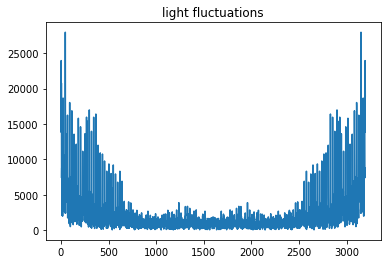

In [12]:
planet = x_train.iloc[1]
plt.title('light fluctuations')
plt.plot(planet,label='raw')
plt.show()

As we can see the data returned from the fourier transform is symetric, so we want to cut it in half to keep only the useful information

In [13]:
x_train = [x_train[i][0:len(x_train[i])//2] for i in range(len(x_train))]
x_test = [x_test[i][0:len(x_test[i])//2] for i in range(len(x_test))]

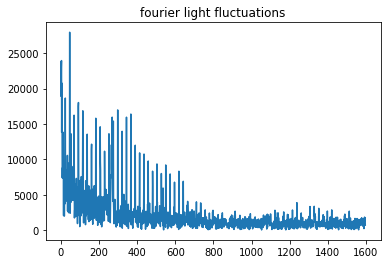

In [14]:
f = x_train[1]
plt.title('fourier light fluctuations')
plt.plot(f,label='fourier')
plt.show()

next we want to normalize the data, apply a gaussian filter, then standardize it again. We apply the gaussian filter because we want to remove any excess noise from the signal, this will smooth the signal out. re-standardizing the data after the gaussian filter allows us to regain negative values which are important

In [15]:
x_train = normalize(x_train)
x_train = gaussian_filter(x_train, sigma=10)
x_train = StandardScaler().fit_transform(x_train)

x_test = normalize(x_test)
x_test = gaussian_filter(x_test, sigma=10)
x_test = StandardScaler().fit_transform(x_test)

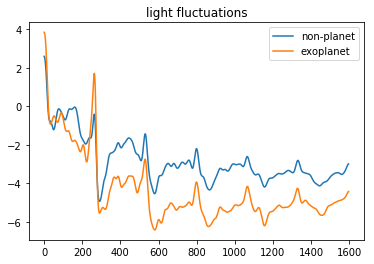

In [16]:
planet = x_train[1]
non_planet = x_train[25]
plt.title('light fluctuations')
plt.plot(non_planet,label='non-planet')
plt.plot(planet,label='exoplanet')
plt.legend()
plt.show()

Lets try using principle component analysis to see if we can reduce the dimensions to 2 and plot it on an xy plane to see if the most important 2 components have some visible seperability

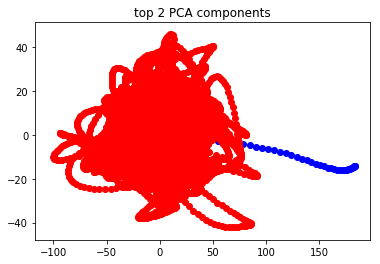

In [17]:
pca = PCA(n_components=2)
data = pca.fit_transform(x_train)
x_list = [d[0] for d in data]
y_list = [d[1] for d in data]

plt.title('top 2 PCA components')
for i in range(len(y_train)):
    if y_train[i] != 0: plt.scatter(x_list[i], y_list[i], color='blue',label='exoplanet')
    else: plt.scatter(x_list[i], y_list[i], color='red', label='non-exoplanet')
plt.show()

We can see a very interesting trend here of displaying the top two components after taking a fourier transformation and applying a gaussian smoothing filter. The exoplanets in blue, seem to fall more on the right side of the graph, while the non exoplanets cluster on the left side of the graph in a ball. 

Because the data set is so inbalanced, we will use a method called SMOTE which allows you to return a data set that has a desired ratio of positive to negative points. It accomplishes this by selecting certain points in the undersampled class and draws a line between them. Then the line is populated with 'fake' new points for the undersampled class. We will use this to balance out the positive and negative samples from the origional data set.

In [18]:
x_smote,y_smote = SMOTE(ratio=1.0).fit_sample(x_train,y_train)

In [19]:
print(f'num cols: {x_smote.shape[0]}')
print(f'positive: {sum(np.where(y_smote==1,1,0))} negative: {sum(np.where(y_smote==0,1,0))}')

num cols: 10100
positive: 5050 negative: 5050


As we can see the shape of the data frame has just about doubled and gave us an even split of positive and negative points. Now we can begin building out models

## Building the models
We are going to be using two models and comparing them, a neural network and a linear support vector classifier.

### Nerual network
We are going to build a nerual network an input size thats the same as the number of features (1598). We will use 1 hiden layer with size 800. This is a binary classification problem, so we use one node in the output layer. For our optimizer we will use stochastic gradient decent, with a binary cross entropy loss function.

In [20]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(1598, activation='relu'),
        keras.layers.Dense(800, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-6),
        metrics=['accuracy']
    )
    
    return model

Now lets train the models...

In [21]:
model_smote = create_model()
model_smote.fit(x_smote,y_smote,epochs=50,batch_size=32,verbose=False)

model_unbalanced = create_model()
model_unbalanced.fit(x_train,y_train,epochs=50,batch_size=32,verbose=False)

#### Neural network with smote

In [22]:
pred_train = model_smote.predict(x_train,batch_size=32)
pred_test = model_smote.predict(x_test,batch_size=32)

acc_train = accuracy_score(y_train.round(),pred_train.round())
acc_test = accuracy_score(y_test.round(),pred_test.round())

mat_train = confusion_matrix(y_train.round(),pred_train.round())
mat_test = confusion_matrix(y_test.round(),pred_test.round())

print('----------------------------------------')
print(f'training accuracy: {acc_train:0.5f}')
print('----------------------------------------')
print(f'testing accuracy: {acc_test:0.5f}')
print('----------------------------------------')
print(f'confusion train matrix: \n {mat_train}')
print('----------------------------------------')
print(f'confusion test matrix: \n {mat_test}')
print('----------------------------------------')

----------------------------------------
training accuracy: 0.99961
----------------------------------------
testing accuracy: 0.99123
----------------------------------------
confusion train matrix: 
 [[5048    2]
 [   0   37]]
----------------------------------------
confusion test matrix: 
 [[565   0]
 [  5   0]]
----------------------------------------


#### Neural network without smote

In [23]:
pred_train = model_unbalanced.predict(x_train,batch_size=32)
pred_test = model_unbalanced.predict(x_test,batch_size=32)

acc_train = accuracy_score(y_train.round(),pred_train.round())
acc_test = accuracy_score(y_test.round(),pred_test.round())

mat_train = confusion_matrix(y_train.round(),pred_train.round())
mat_test = confusion_matrix(y_test.round(),pred_test.round())

print('----------------------------------------')
print(f'training accuracy: {acc_train:0.5f}')
print('----------------------------------------')
print(f'testing accuracy: {acc_test:0.5f}')
print('----------------------------------------')
print(f'confusion train matrix: \n {mat_train}')
print('----------------------------------------')
print(f'confusion test matrix: \n {mat_test}')
print('----------------------------------------')

----------------------------------------
training accuracy: 0.99980
----------------------------------------
testing accuracy: 0.99123
----------------------------------------
confusion train matrix: 
 [[5049    1]
 [   0   37]]
----------------------------------------
confusion test matrix: 
 [[565   0]
 [  5   0]]
----------------------------------------


We can see from both confusion matricies that the neural network overfits the training data, in both cases.

### Support Vector Classifier
Next we are going to build and train both support vector classifiers in an attempt to not overfit the data

In [24]:
model_smote = LinearSVC()
model_smote.fit(x_smote,y_smote)

model_unbalanced = LinearSVC()
model_unbalanced.fit(x_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

#### SVM using smote

In [25]:
pred_train = model_smote.predict(x_train)
pred_test = model_smote.predict(x_test)

acc_train = accuracy_score(y_train,pred_train)
acc_test = accuracy_score(y_test,pred_test)

mat_train = confusion_matrix(y_train,pred_train)
mat_test = confusion_matrix(y_test,pred_test)

print('----------------------------------------')
print(f'training accuracy: {acc_train:0.5f}')
print('----------------------------------------')
print(f'testing accuracy: {acc_test:0.5f}')
print('----------------------------------------')
print(f'confusion train matrix: \n {mat_train}')
print('----------------------------------------')
print(f'confusion test matrix: \n {mat_test}')
print('----------------------------------------')

----------------------------------------
training accuracy: 0.99961
----------------------------------------
testing accuracy: 0.96316
----------------------------------------
confusion train matrix: 
 [[5048    2]
 [   0   37]]
----------------------------------------
confusion test matrix: 
 [[544  21]
 [  0   5]]
----------------------------------------


#### SVM without smote

In [26]:
pred_train = model_unbalanced.predict(x_train)
pred_test = model_unbalanced.predict(x_test)

acc_train = accuracy_score(y_train,pred_train)
acc_test = accuracy_score(y_test,pred_test)

mat_train = confusion_matrix(y_train,pred_train)
mat_test = confusion_matrix(y_test,pred_test)

print('----------------------------------------')
print(f'training accuracy: {acc_train:0.5f}')
print('----------------------------------------')
print(f'testing accuracy: {acc_test:0.5f}')
print('----------------------------------------')
print(f'confusion train matrix: \n {mat_train}')
print('----------------------------------------')
print(f'confusion test matrix: \n {mat_test}')
print('----------------------------------------')

----------------------------------------
training accuracy: 1.00000
----------------------------------------
testing accuracy: 0.98421
----------------------------------------
confusion train matrix: 
 [[5050    0]
 [   0   37]]
----------------------------------------
confusion test matrix: 
 [[556   9]
 [  0   5]]
----------------------------------------


## Conclusion
To start off, we take the data and preprocess it using four different methods. The first and most important is the fourier transformation. This is incredibly useful in signal processing because it allows us to move from a spacial domain to a frequency domain, and when trying to read something like how often a light curve dips, this is very useful. After we transform our data into a frequency domain, this creates a symetric output, due to the nature of fourier transforms. This data then needs to be cut in half, which gives us less features, but decreases the amount of computations in training time. After this its a simple normalization of the data which gets passed to a gaussian filter with a standard deviation of size 10. This very much smooths out the data and gets rid of any unwanted noise, which again is important in signal processing because we dont want to be learning anything about the noise, we want to be learning about the overall pattern. This will help us generalize from the training set to the testing set. The final step in the data preprocessing is to standardize the data, since previously we were only working with positive data, now the data gets standardized so we can see a full range once again. After looking at some of the figures presented in the file here, its pretty obvious to visually see what periodic light dips look like (the orange vs blue graph) and after the data preprocessing, when we use principal component analysis to find a 2d spacial relationship, we can see a very obvious one. With most of the exoplanet data being on the right side of the graph in a line, and the non-exoplanet data being in a ball on the left hand side. This gives us a good indication that support vector machines should work well with classifying this data. We can make this conclusion because when we are not using PCA data, we have many more dimensions, and if only 2 dimensions can see a visual relationship, although we cannot imagine a 1,598 dimension world, we can see that as we add dimensions we get more seperability. We also choose to use a neural network for this project, because in historic attempts of signal processing neural networks can be very useful, but struggle with very unbalanced data sets, so i thought this would be a good challenge.

To combat the unbalanced factor of the data set we use a technique in this project called SMOTE. This is the process of rebalancing data sets by creating fake points to achieve a desired ratio of positive to negative data points. As you can see we want a 1:1 ratio for training. For this project we end up with four total models, 2 nerual networks, trained on the smote data, and on the regular training data, and then 2 linear support vector classifiers, also trained on the smote data, and on the regular training data. SMOTE works as described above in the report, it draws lines between the undersampled points, and then populates those lines with a label for the undersampled data. This assumes that the positive data and negative data have some sort of clustered relationship, which for a lot of data analysis is the case. This is why this is a very good method to use for this data set. But we test with and without SMOTE just to compare again.

First we take a look at the nerual networks preformace. After tweaking the network for a while, with different learning rates and layers i landed on the current model in the notebook. This was a hard model to reach, since the data set was so imbalanced, changing the learning rate or the a layer setup just a little bit had very very large results in the predictions. This makes sense because of how unbalanced the data set is. In the end we can notice after looking at the confusion matricies for both the training with SMOTE, and without SMOTE we get better results across the board using the regular training data set.

The setup ends up using the adam optimizer with a learning rate of 1x10^-6, paired with a binary crossentropy loss function. After some research i found this to be an optimal combination for both the binary classification, and a low learning rate for the small/unbalanced data set. We use an input layer size of 1598, which is the same as the number of features per data point. We use a relu activation here, and feed into a hidden layer of size 800 (about half the number of features) with another relu activation. This finally feeds into our output later, which is size one for the binary classification, and uses a sigmoid activation. We choose to train with a batch size of 32, because once again after some research it seems to be that batch training works best with smaller and unbalanced data sets. 

When using SMOTE for training on the neural network we end up with a training accuracy of 99.9%. We can see from the confusion matrix that we correctly classify 5048 of the non-exoplanets as non-exoplanets, and correctly classify all 37 of the exoplanets as exoplanets. The only mistakes here are classifying 2 of the non-exoplanets as exoplanets, a false negative. When looking at the testing accuracy we see that we get 99.1%. This is a false accuracy, we can clearly see this by looking at the confusion matrix for the testing accuracy, we classify all data points as non-exoplanets, which means that for the only 5 true positives, we predicted them as negative. This means that the model here ends up overfitting to the smote training data, but has very good recall on the training data.

When using just the regular training, meaning not applying the SMOTE algorithm, on the nerual network, we end up with a training accuracy of 99.9%. This means we achived almost perfect recal on the training data set, we can see this result in the confusion matrix, where the diagonals are the number of negative poits and positive points, with the off diagonals being 0 except the top right, which classified 1 non-exoplanet as a positive. When looking at the testing data, we end up with a similar issue as beofre, we overfit to the training data. This can be seen with the same really high accuracy, but a confusion matrix showing us that we are classifying everything as negative. 

No matter how much i ended up tweaking the network the results were always the same, even with no hidden layers in an attempt to not over fit the data. we would either end up with classfying everything as an exoplanet, and getting evry low accuracies, across both the testing and training predictions. The best results i was able to achieve was perfect recall of the trianing data sets without using SMOTE, and no correct classifications on the testing data. This was another reason why i was curious to see if we could classify using a SVM, which is a powerful tool and less senstive than a neural network.

Support vector machines sometimes are known preform better on certain data sets than neural networks. With a relatively small data set (only around 5000 data points) and being highly unbalanced, i was curious to see if a SVM would preform better on this data set, and help out with our overfitting problem.

When fitting the linear support vector classifier on the SMOTE data, we ended up with a training accuracy of 99.9%, almost perfect recall. when looking at the confusion matrix we see that we correctly classify almost all 5050 non-exoplanet data points. We only classify two non-exoplanet data point as a positive. We also see that we correctly classify all 37 of positive data points as positive. When predicting on the testing data set, we see that we start to fix our overfitting problem. We correclty classify all of the exoplanets as positive, and only 21 of the non-exoplanets as postive labels. This achieves an accuracy of 96%, which for this data set (being very unbalanced) is a good accuracy.

When fitting the linear support vector classifier on the non SMOTE data, we end up with a training accuracy of 100%, perfect recall, just like with the neural network. But with the SVC we when we predict the testing data, we end up with an accuracy of 98%, and less false negatives than the previous data fitted to SMOTE. this can be seen in the confusion matrix, where we only classify 9 of the non-exoplanets as positive, and correctly classify the rest of the data set. This is a very good result for this data set, where out of the 570 points, with only 5 being positive, we only predict 9 as positive (4 mistakes and 5 correct).

When comparing these two models, we can see that the linear support vector classifer preforms better across the board, it does better with the SMOTE data, and without the SMOTE data across both training and testing accuracies. I do however think that if this were a more balanced data set from NASA, and possibly larger, the neural network would end up out preforming the SVM when it comes to generalizing. This however might never be the case, since data collection like this is very expensive and difficult. If we want more positive data points, we have to find more confirmed exoplanets using a different method. NASA open sourced this project when it first came out, which is why all the data is available. Overall it was a very interesting learning experience, working with binary cross entropy can be tricky, espeically with unbalanced data sets since it makes them very senseitive. Being able to reinforce the pros and cons of SVM's vs neural networks on different kinds of data. We also learn from this that SMOTE is not perfect, it can only be as good as the data set that it is provided. When looking at the red vs blue plot after principal component analysis, we see that the data isnt perfectly seperated, meaning a lot of the new positive data points will be in the same region as the negative data points, making it impossible to perfectly classify the data set. But SMOTE however was an interesting method to use, and a good tool to have with unbalanced data sets.